# Agentic AI for Transport Mode Optimization

This notebook demonstrates the use of deep learning and agentic decision-making to optimize transport mode selection for freight shipments using the Freight Analysis Framework dataset. It integrates a cost-predicting neural network with a goal-driven agent and a reinforcement learning Q-agent to make intelligent, future-aware decisions.

**Core Components:**
- Neural Network model for shipment cost prediction
- Goal-driven agent supporting 'cheapest', 'fastest', or 'balanced' decisions
- Future shipment forecasting using dynamic feature scaling and interpolation
- Q-learning agent that learns optimal modes from simulated rewards


## Dataset Preprocessing & Balancing

In [ ]:
import pandas as pd

# Load the dataset (Replace 'your_file.csv' with actual file name)
file_path = "/content/FAF4_Regional.csv"
df = pd.read_csv(file_path)

# Select only the relevant columns for our AI model
df = df[["dms_orig", "dms_dest", "dms_mode", "tons_2012", "value_2012", "tmiles_2012", "trade_type"]]

# Filter for domestic shipments only (trade_type == 1)
df = df[df["trade_type"] == 1]

# Drop trade_type column since it's now redundant
df.drop(columns=["trade_type"], inplace=True)

# Display cleaned dataset
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Cleaned FAF Dataset", dataframe=df)
df.head(5)


,dms_orig,dms_dest,dms_mode,tons_2012,value_2012,tmiles_2012
0,11,11,1,17.3922,32.9385,0.3237
1,11,19,1,220.0650,269.8723,25.3876
2,11,129,1,1.0854,1.5510,0.6798
3,11,131,1,6.1655,9.6137,1.5839
4,11,139,1,2.7483,4.1406,0.8705


**Visualizing the data**

<ipython-input-16-ac7c7493c53e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mode_counts.index, y=mode_counts.values, palette="viridis")


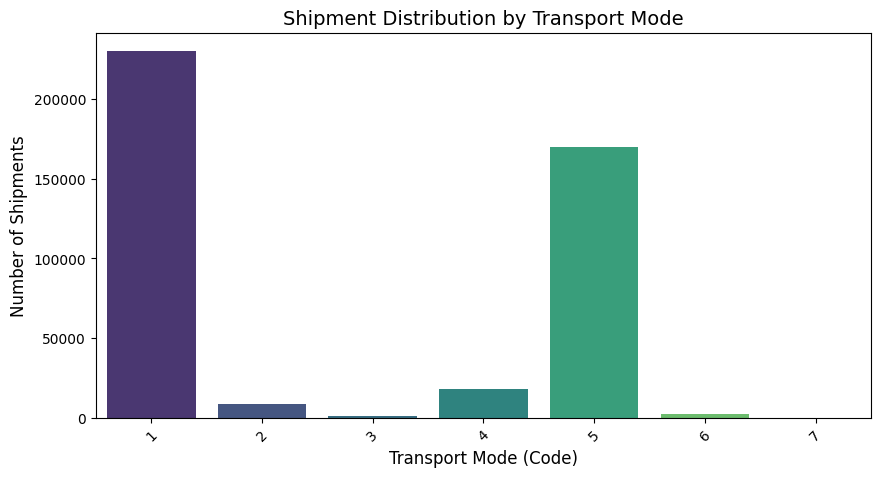

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10, 5))

# Count shipments per transport mode
mode_counts = df["dms_mode"].value_counts()

# Plot shipment distribution by transport mode
sns.barplot(x=mode_counts.index, y=mode_counts.values, palette="viridis")

# Labeling
plt.xlabel("Transport Mode (Code)", fontsize=12)
plt.ylabel("Number of Shipments", fontsize=12)
plt.title("Shipment Distribution by Transport Mode", fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.show()


## Cost vs Distance Analysis

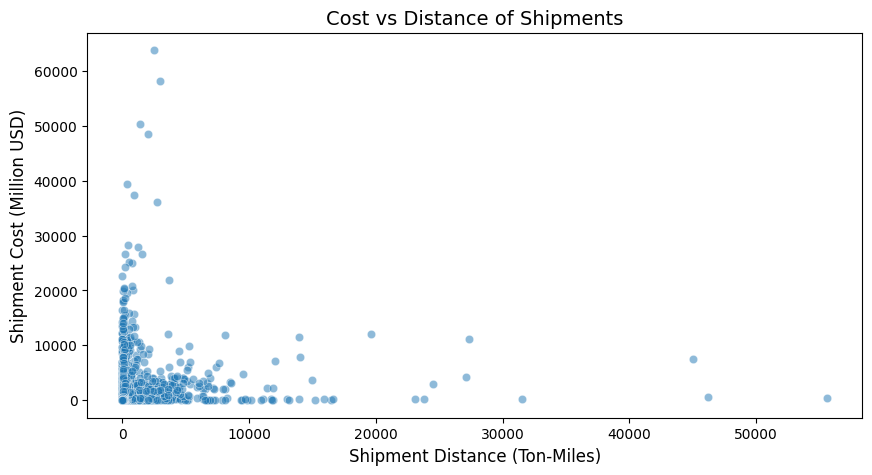

In [ ]:
# Scatter plot: Cost vs. Distance (tmiles_2012 vs. value_2012)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["tmiles_2012"], y=df["value_2012"], alpha=0.5)

# Labeling
plt.xlabel("Shipment Distance (Ton-Miles)", fontsize=12)
plt.ylabel("Shipment Cost (Million USD)", fontsize=12)
plt.title("Cost vs Distance of Shipments", fontsize=14)

# Show plot
plt.show()


**Key shipping regions - msot common shipping destinations**

In [ ]:
# Bar plot: Top 10 Origin Regions with Most Shipments
plt.figure(figsize=(12, 6))
top_origins = df["dms_orig"].value_counts().head(10)

sns.barplot(x=top_origins.index, y=top_origins.values, palette="coolwarm")

# Labeling
plt.xlabel("Origin Region (FAF Code)", fontsize=12)
plt.ylabel("Number of Shipments", fontsize=12)
plt.title("Top 10 Shipment Origin Regions", fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.show()

# Bar plot: Top 10 Destination Regions with Most Shipments
plt.figure(figsize=(12, 6))
top_destinations = df["dms_dest"].value_counts().head(10)

sns.barplot(x=top_destinations.index, y=top_destinations.values, palette="coolwarm")

# Labeling
plt.xlabel("Destination Region (FAF Code)", fontsize=12)
plt.ylabel("Number of Shipments", fontsize=12)
plt.title("Top 10 Shipment Destination Regions", fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.show()


NameError: name 'plt' is not defined

## Deep Neural Network for Cost Prediction

**Data preprocessing - Converting transportation modes into numerical**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# ✅ Step 1: Map numeric transport modes to string labels
mode_mapping = {
    1: "Truck",
    2: "Rail",
    3: "Water",
    4: "Air",
    5: "Multiple_Modes_and_Mail",
    6: "Pipeline",
    7: "Other_and_Unknown"
}
df["dms_mode"] = df["dms_mode"].map(mode_mapping)

# ✅ Step 2: One-hot encode transport mode
df = pd.get_dummies(df, columns=["dms_mode"], prefix="dms_mode", dtype=int)

# ✅ Step 3: Balance dataset AFTER one-hot encoding
mode_counts = df.filter(like="dms_mode_").sum()  # Count occurrences of each mode
min_samples = mode_counts.min()  # Find the least represented mode count

balanced_df_list = []
for mode in mode_counts.index:
    mode_subset = df[df[mode] == 1]  # Get all rows where this mode is active
    balanced_mode = resample(mode_subset, replace=True, n_samples=min_samples, random_state=42)
    balanced_df_list.append(balanced_mode)

# ✅ Step 4: Create balanced dataset
df_balanced = pd.concat(balanced_df_list)

print("✅ Dataset balanced with equal transport mode representation!")

# ✅ Step 5: Normalize numerical features
scaler = MinMaxScaler()
df_balanced[["tons_2012", "value_2012", "tmiles_2012"]] = scaler.fit_transform(
    df_balanced[["tons_2012", "value_2012", "tmiles_2012"]]
)

# ✅ Step 6: Display to confirm
print("✅ Final columns after processing:")
print(df_balanced.columns.tolist())
print(df_balanced.head())


✅ Dataset balanced with equal transport mode representation!
✅ Final columns after processing:
['dms_orig', 'dms_dest', 'tons_2012', 'value_2012', 'tmiles_2012', 'dms_mode_Air', 'dms_mode_Multiple_Modes_and_Mail', 'dms_mode_Other_and_Unknown', 'dms_mode_Pipeline', 'dms_mode_Rail', 'dms_mode_Truck', 'dms_mode_Water']
         dms_orig  dms_dest  tons_2012  value_2012  tmiles_2012  dms_mode_Air  \
1492688        81       373   0.000004    0.000036     0.000049             1   
273562        341        61   0.000016    0.000137     0.000287             1   
851209         41       223   0.000003    0.000000     0.000028             1   
1288889        62        42   0.000010    0.000044     0.000060             1   
1223499       339       559   0.000005    0.000026     0.000050             0   

         dms_mode_Multiple_Modes_and_Mail  dms_mode_Other_and_Unknown  \
1492688                                 0                           0   
273562                                  0        

In [ ]:
# print(X_train.dtypes)
df["cost_per_mile"] = df["value_2012"] / (df["tmiles_2012"] + 1e-5)  # Avoid division by zero
df["region_pair"] = df["dms_orig"].astype(str) + "_" + df["dms_dest"].astype(str)  # Categorical route pair

# One-hot encode region pair
df = pd.get_dummies(df, columns=["region_pair"], prefix="route")

print("✅ New features added successfully!")
df.head(5)

✅ New features added successfully!


,dms_orig,dms_dest,tons_2012,value_2012,tmiles_2012,dms_mode_Air,dms_mode_Multiple_Modes_and_Mail,dms_mode_Other_and_Unknown,dms_mode_Pipeline,dms_mode_Rail,...,route_99_62,route_99_63,route_99_64,route_99_65,route_99_69,route_99_81,route_99_89,route_99_91,route_99_92,route_99_99
0,11,11,17.3922,32.9385,0.3237,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,11,19,220.0650,269.8723,25.3876,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,11,129,1.0854,1.5510,0.6798,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,11,131,6.1655,9.6137,1.5839,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,11,139,2.7483,4.1406,0.8705,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


**Feed Forward NN for interpretation**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Convert all categorical values to integer (to avoid PyTorch dtype issues)
df = df_balanced.astype(float)
X = df.drop(columns=["value_2012"])
y = df["value_2012"]

# ✅ Step 2: Split into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors & move to GPU
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)



# ✅ Step 3: Create DataLoader for Mini-Batch Processing
batch_size = 1024  # Mini-batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Step 5: Define the Neural Network Model with Dropout
class ShipmentNN(nn.Module):
    def __init__(self, input_size):
        super(ShipmentNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(p=0.4)  # Drop 30% of neurons
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# ✅ Initialize model
input_size = X_train.shape[1]
model = ShipmentNN(input_size).to(device)


# ✅ Define Loss Function & Optimizer with L2 Regularization (weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 penalty added here


# ✅ Step 6: Train the Neural Network using Mini-Batches
# Train the Neural Network with GPU
epochs = 400
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # ✅ Move batch to GPU

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

print("✅ Training Completed with GPU Acceleration!")

# ✅ Step 7: Evaluate the Model on Test Data
with torch.no_grad():
    test_losses = []
    for batch_X, batch_y in test_loader:
        y_pred_test = model(batch_X)
        loss = criterion(y_pred_test, batch_y)
        test_losses.append(loss.item())

    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"\nFinal Test Loss: {avg_test_loss:.6f}")

print("\nMini-Batch Training Completed Successfully!")


Epoch 10/400, Loss: 172.2780
Epoch 20/400, Loss: 169.7106
Epoch 30/400, Loss: 189.2227
Epoch 40/400, Loss: 112.8165
Epoch 50/400, Loss: 60.4844
Epoch 60/400, Loss: 29.5165
Epoch 70/400, Loss: 18.9398
Epoch 80/400, Loss: 22.8009
Epoch 90/400, Loss: 10.4497
Epoch 100/400, Loss: 16.0717
Epoch 110/400, Loss: 15.7393
Epoch 120/400, Loss: 1.9050
Epoch 130/400, Loss: 10.2145
Epoch 140/400, Loss: 16.0980
Epoch 150/400, Loss: 6.2199
Epoch 160/400, Loss: 8.9724
Epoch 170/400, Loss: 12.5483
Epoch 180/400, Loss: 4.4016
Epoch 190/400, Loss: 4.9155
Epoch 200/400, Loss: 1.9454
Epoch 210/400, Loss: 1.8528
Epoch 220/400, Loss: 5.4490
Epoch 230/400, Loss: 2.7922
Epoch 240/400, Loss: 1.6702
Epoch 250/400, Loss: 2.1246
Epoch 260/400, Loss: 1.2687
Epoch 270/400, Loss: 0.8306
Epoch 280/400, Loss: 8.6317
Epoch 290/400, Loss: 0.6458
Epoch 300/400, Loss: 3.3537
Epoch 310/400, Loss: 1.2659
Epoch 320/400, Loss: 2.1145
Epoch 330/400, Loss: 0.7776
Epoch 340/400, Loss: 2.6452
Epoch 350/400, Loss: 0.3238
Epoch 360/4

In [ ]:
sample = X_test_tensor[0].unsqueeze(0)
predicted_cost = model(sample).item()
print(predicted_cost)
# Ensure predicted costs have the same shape as training data
predicted_costs = predicted_cost.reshape(1, -1)  # Reshape if necessary

# Apply inverse transformation
predicted_costs = scaler.inverse_transform(predicted_costs)


-0.27017611265182495


AttributeError: 'float' object has no attribute 'reshape'

In [ ]:
import pandas as pd


file_path = "/content/drive/MyDrive/Colab Notebooks/FAF4_Regional.csv"
df = pd.read_csv(file_path)
# Select only the relevant columns for our AI model
df = df[["dms_orig", "dms_dest", "dms_mode", "tons_2012", "value_2012", "tmiles_2012", "trade_type"]]
# Filter for domestic shipments only (trade_type == 1)
df = df[df["trade_type"] == 1]

# Drop trade_type column since it's now redundant
df.drop(columns=["trade_type"], inplace=True)

# Display cleaned dataset
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Cleaned FAF Dataset", dataframe=df)
df.head(5)



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# **Step 1: Data Preprocessing & Balancing**
# Convert transport mode from numeric to categorical labels
mode_mapping = {
    1: "Truck", 2: "Rail", 3: "Water", 4: "Air", 5: "Multiple_Modes_and_Mail", 6: "Pipeline", 7: "Other_and_Unknown"
}
df["dms_mode"] = df["dms_mode"].map(mode_mapping)

# One-hot encode transport mode
df = pd.get_dummies(df, columns=["dms_mode"], prefix="dms_mode", dtype=int)

# Balance dataset to ensure all transport modes have equal representation
mode_counts = df.filter(like="dms_mode_").sum()
min_samples = mode_counts.min()

balanced_df_list = []
for mode in mode_counts.index:
    mode_subset = df[df[mode] == 1]
    balanced_mode = resample(mode_subset, replace=True, n_samples=min_samples, random_state=42)
    balanced_df_list.append(balanced_mode)

df_balanced = pd.concat(balanced_df_list)

print("✅ Dataset balanced with equal transport mode representation!")

# **Step 2: Feature Scaling**
# Use a separate scaler for shipment cost (`value_2012`)
scaler_value = MinMaxScaler()
df_balanced["value_2012"] = scaler_value.fit_transform(df_balanced[["value_2012"]])

# Normalize other numerical features
scaler_features = MinMaxScaler()
df_balanced[["tons_2012", "tmiles_2012"]] = scaler_features.fit_transform(df_balanced[["tons_2012", "tmiles_2012"]])

# **Step 3: Split Data**
X = df_balanced.drop(columns=["value_2012"])
y = df_balanced["value_2012"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to float32 for memory efficiency
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# **Step 4: Move Data to GPU Efficiently**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader with mini-batch processing
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# **Step 5: Define Neural Network with L2 Regularization & Dropout**
class ShipmentNN(nn.Module):
    def __init__(self, input_size):
        super(ShipmentNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Model
input_size = X_train.shape[1]
model = ShipmentNN(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# **Step 6: Train the Neural Network**
epochs = 400
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

print("✅ Training Completed with GPU Acceleration!")

# **Step 7: Model Evaluation**
with torch.no_grad():
    test_losses = []
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)
        y_pred_test = model(batch_X)
        loss = criterion(y_pred_test, batch_y)
        test_losses.append(loss.item())

    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"\n🔍 Final Test Loss: {avg_test_loss:.4f}")



✅ Dataset balanced with equal transport mode representation!
✅ Using device: cpu
Epoch 10/400, Loss: 64.1876
Epoch 20/400, Loss: 14.4275
Epoch 30/400, Loss: 9.1823
Epoch 40/400, Loss: 7.0295
Epoch 50/400, Loss: 10.1086
Epoch 60/400, Loss: 3.9991
Epoch 70/400, Loss: 6.0406
Epoch 80/400, Loss: 2.4133
Epoch 90/400, Loss: 2.6887
Epoch 100/400, Loss: 2.5248
Epoch 110/400, Loss: 0.6048
Epoch 120/400, Loss: 2.1391
Epoch 130/400, Loss: 1.5399
Epoch 140/400, Loss: 1.3703
Epoch 150/400, Loss: 3.5367
Epoch 160/400, Loss: 2.4571
Epoch 170/400, Loss: 1.4759
Epoch 180/400, Loss: 2.0891
Epoch 190/400, Loss: 1.2134
Epoch 200/400, Loss: 0.9108
Epoch 210/400, Loss: 1.1049
Epoch 220/400, Loss: 0.5122
Epoch 230/400, Loss: 0.6041
Epoch 240/400, Loss: 0.7291
Epoch 250/400, Loss: 1.0504
Epoch 260/400, Loss: 0.4970
Epoch 270/400, Loss: 0.8373
Epoch 280/400, Loss: 1.3018
Epoch 290/400, Loss: 0.3740
Epoch 300/400, Loss: 0.4610
Epoch 310/400, Loss: 0.3923
Epoch 320/400, Loss: 0.3341
Epoch 330/400, Loss: 0.4199
E

In [ ]:
df_balanced.head(5)

,dms_orig,dms_dest,tons_2012,value_2012,tmiles_2012,dms_mode_Air,dms_mode_Multiple_Modes_and_Mail,dms_mode_Other_and_Unknown,dms_mode_Pipeline,dms_mode_Rail,dms_mode_Truck,dms_mode_Water
1492688,81,373,0.000004,0.000036,0.000049,1,0,0,0,0,0,0
273562,341,61,0.000016,0.000137,0.000287,1,0,0,0,0,0,0
851209,41,223,0.000003,0.000000,0.000028,1,0,0,0,0,0,0
1288889,62,42,0.000010,0.000044,0.000060,1,0,0,0,0,0,0
1223499,339,559,0.000005,0.000026,0.000050,0,1,0,0,0,0,0


In [ ]:
df.head(5)

,dms_orig,dms_dest,tons_2012,value_2012,tmiles_2012,dms_mode_Air,dms_mode_Multiple_Modes_and_Mail,dms_mode_Other_and_Unknown,dms_mode_Pipeline,dms_mode_Rail,dms_mode_Truck,dms_mode_Water
0,11,11,17.3922,32.9385,0.3237,0,0,0,0,0,1,0
1,11,19,220.0650,269.8723,25.3876,0,0,0,0,0,1,0
2,11,129,1.0854,1.5510,0.6798,0,0,0,0,0,1,0
3,11,131,6.1655,9.6137,1.5839,0,0,0,0,0,1,0
4,11,139,2.7483,4.1406,0.8705,0,0,0,0,0,1,0


In [ ]:
def recommend_transport_mode(sample_shipment, model, device, feature_columns):
    sample_shipment = sample_shipment.copy()

    # Drop transport mode columns from base features
    base_features = sample_shipment.drop(columns=[col for col in sample_shipment if col.startswith("dms_mode_")])

    # Get all possible transport modes from training data
    transport_modes = [col for col in feature_columns if col.startswith("dms_mode_")]

    predicted_costs = []
    for mode in transport_modes:
        sample_copy = base_features.copy()

        # Create a complete feature set with missing transport mode columns filled with 0
        sample_full = pd.DataFrame(columns=feature_columns)  # Create an empty DataFrame with correct columns
        sample_full.loc[0] = 0  # Fill with zeros
        sample_full.update(sample_copy)  # Update with actual sample features
        sample_full[mode] = 1  # Set the current transport mode as active

        # Convert sample to tensor & ensure it has the correct feature count
        sample_tensor = torch.tensor(sample_full.values, dtype=torch.float32).to(device)

        # Predict cost
        cost_prediction = model(sample_tensor).cpu().detach().numpy()
        cost_prediction = scaler_value.inverse_transform(cost_prediction.reshape(1, -1))[0][0]

        predicted_costs.append((mode, cost_prediction))

    # Sort by predicted cost
    predicted_costs.sort(key=lambda x: x[1])

    # Display results
    print("\n📦 Predicted Costs by Mode:")
    for mode, cost in predicted_costs:
        print(f"{mode}: ${cost:.4f}")

    print(f"\n✅ Recommended Mode: **{predicted_costs[0][0]}** (Cheapest)")
    return predicted_costs[0][0]

# **Run Recommendation**
if len(X_test) > 0:
    random_sample = X_test.sample(n=1, random_state=42)
    best_mode = recommend_transport_mode(random_sample, model, device, X_train.columns)
else:
    print("Error: X_test is empty!")



📦 Predicted Costs by Mode:
dms_mode_Other_and_Unknown: $-859.9753
dms_mode_Multiple_Modes_and_Mail: $-827.4379
dms_mode_Air: $-820.8067
dms_mode_Water: $-816.1255
dms_mode_Rail: $-795.5306
dms_mode_Pipeline: $-794.4457
dms_mode_Truck: $-752.7577

✅ Recommended Mode: **dms_mode_Other_and_Unknown** (Cheapest)


**Defining Agent - Base agent based on cheapest transport mode**

In [ ]:
class TransportModeAgent:
    def __init__(self, model, device, feature_columns, scaler):
        self.model = model
        self.device = device
        self.feature_columns = feature_columns
        self.scaler = scaler  # MinMaxScaler used for cost normalization

    def decide(self, shipment):
        shipment = shipment.copy()

        # Remove all transport mode flags
        base_features = shipment.drop(columns=[col for col in shipment if col.startswith("dms_mode_")])

        # All available mode options
        mode_columns = [col for col in self.feature_columns if col.startswith("dms_mode_")]
        decisions = []

        for mode in mode_columns:
            sample = pd.DataFrame(columns=self.feature_columns)
            sample.loc[0] = 0  # Fill all with zeros
            sample.update(base_features)  # Fill in the actual shipment data
            sample[mode] = 1  # Activate this mode

            # Predict cost
            tensor_sample = torch.tensor(sample.values, dtype=torch.float32).to(self.device)
            normalized_cost = self.model(tensor_sample).cpu().detach().numpy()

            # Convert back to real cost
            actual_cost = self.scaler.inverse_transform(normalized_cost.reshape(1, -1))[0][0]

            decisions.append((mode, actual_cost))

        # Pick the mode with the lowest cost (highest reward)
        best_mode, best_cost = min(decisions, key=lambda x: x[1])

        # Logging decision
        print("\n🧠 Agent Cost Predictions:")
        for mode, cost in decisions:
            print(f"{mode}: ${cost:.2f}")
        print(f"\n✅ Agent selects: {best_mode} with predicted cost: ${best_cost:.2f}")

        return best_mode, best_cost


**Running the agent**

In [ ]:
# Instantiate the Agent
agent = TransportModeAgent(model=model, device=device, feature_columns=X_train.columns, scaler=scaler_value)

# Pick a test sample
test_shipment = X_test.sample(n=1, random_state=42)

# Agent makes a decision
best_mode, predicted_cost = agent.decide(test_shipment)



🧠 Agent Cost Predictions:
dms_mode_Air: $972.25
dms_mode_Multiple_Modes_and_Mail: $872.50
dms_mode_Other_and_Unknown: $947.24
dms_mode_Pipeline: $914.06
dms_mode_Rail: $947.04
dms_mode_Truck: $837.67
dms_mode_Water: $854.18

✅ Agent selects: dms_mode_Truck with predicted cost: $837.67


## Goal-Driven Agent Design

In [ ]:
class GoalDrivenAgent:
    def __init__(self, model, device, feature_columns, cost_scaler, feature_scaler, year, goal="cheapest", alpha=0.7, beta=0.3):
        self.model = model
        self.device = device
        self.feature_columns = feature_columns
        self.cost_scaler = cost_scaler
        self.feature_scaler = feature_scaler
        self.year = year  # Target year for prediction
        self.goal = goal  # "cheapest", "fastest", "balanced"
        self.alpha = alpha  # Weight for cost
        self.beta = beta    # Weight for distance

    def decide(self, shipment):
        shipment = shipment.copy()
        base_features = shipment.drop(columns=[col for col in shipment if col.startswith("dms_mode_")])
        mode_columns = [col for col in self.feature_columns if col.startswith("dms_mode_")]

        decisions = []

        for mode in mode_columns:
            sample = pd.DataFrame(columns=self.feature_columns)
            sample.loc[0] = 0
            sample.update(base_features)
            sample[mode] = 1

            # Predict cost
            tensor_sample = torch.tensor(sample.values, dtype=torch.float32).to(self.device)
            normalized_cost = self.model(tensor_sample).cpu().detach().numpy()
            cost = self.cost_scaler.inverse_transform(normalized_cost.reshape(1, -1))[0][0]

            # Dynamically extract distance column
            tons_col = f"tons_{self.year}" if f"tons_{self.year}" in shipment.columns else "tons_2012"
            tmiles_col = f"tmiles_{self.year}" if f"tmiles_{self.year}" in shipment.columns else "tmiles_2012"


            # Retrieve scaled distance and tons from input
            distance_scaled = shipment[tmiles_col].values[0]
            tons_scaled = shipment[tons_col].values[0]

            # Unscale using the feature scaler
            unscaled_values = self.feature_scaler.inverse_transform([[tons_scaled, distance_scaled]])
            distance = unscaled_values[0][1]  # Extract distance

            # Compute reward based on the selected goal
            if self.goal == "cheapest":
                reward = -cost
            elif self.goal == "fastest":
                reward = -distance
            elif self.goal == "balanced":
                reward = -self.alpha * cost - self.beta * distance
            else:
                raise ValueError("Invalid goal specified.")

            decisions.append((mode, cost, distance, reward))

        # Pick the best mode based on reward
        best_mode = max(decisions, key=lambda x: x[3])
        print("\n🧠 Goal-Driven Agent Decision Summary:")
        for mode, cost, distance, reward in decisions:
            print(f"{mode}: Cost=${cost:.2f}, Distance={distance:.2f}, Reward={reward:.2f}")

        print(f"\n✅ Selected Mode: {best_mode[0]} based on goal '{self.goal}'")
        return best_mode[0]


**Testing goal driven agent**

In [ ]:
# 🔁 Re-instantiate the agent for future prediction
agent_future = GoalDrivenAgent(
    model=model,
    device=device,
    feature_columns=X_train.columns,
    cost_scaler=scaler_value,
    feature_scaler=scaler_features,
    year=2030,
    goal="balanced",       # "cheapest", "fastest", "balanced"
    alpha=0.7,
    beta=0.3     # 🗓️ Year you want to forecast for
)

# 🎯 Pick a future shipment (from your already prepared df_2030 or dynamically)
future_shipment = df_original.sample(n=1, random_state=42)

# 💡 Run the agent's decision
best_future_mode = agent_future.decide(future_shipment)



🧠 Goal-Driven Agent Decision Summary:
dms_mode_Air: Cost=$673.52, Distance=507.62, Reward=-623.75
dms_mode_Multiple_Modes_and_Mail: Cost=$742.71, Distance=507.62, Reward=-672.18
dms_mode_Other_and_Unknown: Cost=$744.91, Distance=507.62, Reward=-673.72
dms_mode_Pipeline: Cost=$730.56, Distance=507.62, Reward=-663.68
dms_mode_Rail: Cost=$738.51, Distance=507.62, Reward=-669.25
dms_mode_Truck: Cost=$751.12, Distance=507.62, Reward=-678.07
dms_mode_Water: Cost=$787.43, Distance=507.62, Reward=-703.49

✅ Selected Mode: dms_mode_Air based on goal 'balanced'


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load CSV
df_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FAF4_Regional.csv")

# Step 2: Filter for relevant columns (including all projected years)
df_original = df_original[[
    "dms_orig", "dms_dest", "dms_mode", "trade_type"
] +
[   # Tons, value, and tmiles projection columns
    f"tons_{year}" for year in [2012, 2020, 2025, 2030, 2035, 2040, 2045]
] +
[
    f"value_{year}" for year in [2012, 2020, 2025, 2030, 2035, 2040, 2045]
] +
[
    f"tmiles_{year}" for year in [2012, 2020, 2025, 2030, 2035, 2040, 2045]
]]

# Step 3: Domestic shipments only
df_original = df_original[df_original["trade_type"] == 1].drop(columns=["trade_type"])

# Step 4: Convert transport mode codes to labels
mode_mapping = {
    1: "Truck",
    2: "Rail",
    3: "Water",
    4: "Air",
    5: "Multiple_Modes_and_Mail",
    6: "Pipeline",
    7: "Other_and_Unknown"
}
df_original["dms_mode"] = df_original["dms_mode"].map(mode_mapping)

# Step 5: One-hot encode transport mode using readable names
df_original = pd.get_dummies(df_original, columns=["dms_mode"], prefix="dms_mode", dtype=int)

# ✅ This is your raw full dataset with projections intact
df_original = df_original.copy()
print("✅ df_original defined. Shape:", df_original.shape)






✅ df_original defined. Shape: (430441, 30)


## Future Scenario Forecasting (2050 Projection)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FAF4_Regional.csv")

In [ ]:
df_original.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2012,...,tmiles_2015,tmiles_2020,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,curval_2013,curval_2014,curval_2015
0,NaN,11,11,NaN,NaN,1,NaN,1,1,17.3922,...,0.3817,0.4318,0.4791,0.5265,0.5854,0.6449,0.6656,36.7205,46.3411,42.7443
1,NaN,11,19,NaN,NaN,1,NaN,1,1,220.0650,...,25.7995,27.4014,28.5980,29.6591,30.9511,32.5587,33.8550,283.6623,333.8676,301.8007
2,NaN,11,129,NaN,NaN,1,NaN,1,1,1.0854,...,0.5211,0.5033,0.4917,0.4819,0.4688,0.4860,0.5272,1.3439,1.4783,1.3083
3,NaN,11,131,NaN,NaN,1,NaN,1,1,6.1655,...,1.4469,1.3902,1.4049,1.4619,1.5058,1.5015,1.6357,10.7475,10.9878,9.6642
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2.7483,...,0.7550,0.6872,0.6569,0.6488,0.6353,0.6072,0.6476,4.5875,4.5780,3.9517


In [ ]:
# Re-import necessary libraries after state reset
import torch
import pandas as pd
from typing import Optional, Dict
from sklearn.preprocessing import MinMaxScaler

# Re-define the updated GoalDrivenAgent class after kernel reset
class GoalDrivenAgent:
    def __init__(
        self,
        model,
        device,
        feature_columns,
        cost_scaler,
        feature_scaler,
        year: int,
        goal: str = "cheapest",
        alpha: float = 0.7,
        beta: float = 0.3,
        custom_distances: Optional[Dict[str, float]] = None  # key: mode column name
    ):
        self.model = model
        self.device = device
        self.feature_columns = feature_columns
        self.cost_scaler = cost_scaler
        self.feature_scaler = feature_scaler
        self.year = year
        self.goal = goal
        self.alpha = alpha
        self.beta = beta
        self.custom_distances = custom_distances or {}

    def decide(self, shipment: pd.DataFrame):
        shipment = shipment.copy()
        base_features = shipment.drop(columns=[col for col in shipment if col.startswith("dms_mode_")])
        mode_columns = [col for col in self.feature_columns if col.startswith("dms_mode_")]

        decisions = []

        for mode in mode_columns:
            sample = pd.DataFrame(columns=self.feature_columns)
            sample.loc[0] = 0
            sample.update(base_features)
            sample[mode] = 1

            # Predict cost
            tensor_sample = torch.tensor(sample.values, dtype=torch.float32).to(self.device)
            normalized_cost = self.model(tensor_sample).cpu().detach().numpy()
            cost = self.cost_scaler.inverse_transform(normalized_cost.reshape(1, -1))[0][0]

            # Determine distance
            if mode in self.custom_distances:
                distance = self.custom_distances[mode]  # Use custom override
            else:
                tmiles_col = f"tmiles_{self.year}"
                tons_col = f"tons_{self.year}"
                distance_scaled = shipment[tmiles_col].values[0]
                tons_scaled = shipment[tons_col].values[0]
                unscaled_values = self.feature_scaler.inverse_transform([[tons_scaled, distance_scaled]])
                distance = unscaled_values[0][1]  # Extract unscaled distance

            # Compute reward
            if self.goal == "cheapest":
                reward = -cost
            elif self.goal == "fastest":
                reward = -distance
            elif self.goal == "balanced":
                reward = -self.alpha * cost - self.beta * distance
            else:
                raise ValueError("Invalid goal specified. Use 'cheapest', 'fastest', or 'balanced'.")

            decisions.append((mode, cost, distance, reward))

        best_mode = max(decisions, key=lambda x: x[3])

        print("\nGoal-Driven Agent Decision Summary:")
        for mode, cost, distance, reward in decisions:
            print(f"{mode}: Cost=${cost:.2f}, Distance={distance:.2f}, Reward={reward:.2f}")
        print(f"\nSelected Mode: {best_mode[0]} based on goal '{self.goal}'")

        return best_mode[0]


In [ ]:
custom_distances = {
    "dms_mode_Truck": 12000.5
}


## Q-Learning Agent for Route Optimization

In [ ]:
agent = GoalDrivenAgent(
    model=model,
    device=device,
    feature_columns=X_train.columns,
    cost_scaler=scaler_value,
    feature_scaler=scaler_features,
    year=2030,
    goal="balanced",  # or "cheapest", "fastest"
    alpha=0.6,
    beta=0.4,
    custom_distances=custom_distances  # Optional
)
sample_2030 = df_original.sample(n=1, random_state=42)
agent.decide(sample_2030)


🧠 Goal-Driven Agent Decision Summary:
dms_mode_Air: Cost=$981.49, Distance=607.16, Reward=-831.76
dms_mode_Multiple_Modes_and_Mail: Cost=$892.53, Distance=607.16, Reward=-778.38
dms_mode_Other_and_Unknown: Cost=$950.60, Distance=607.16, Reward=-813.23
dms_mode_Pipeline: Cost=$925.92, Distance=607.16, Reward=-798.41
dms_mode_Rail: Cost=$1003.57, Distance=607.16, Reward=-845.01
dms_mode_Truck: Cost=$988.61, Distance=12000.50, Reward=-5393.37
dms_mode_Water: Cost=$1059.45, Distance=607.16, Reward=-878.54

✅ Selected Mode: dms_mode_Multiple_Modes_and_Mail based on goal 'balanced'


'dms_mode_Multiple_Modes_and_Mail'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_dynamic_year_shipment(df_original, year, scaler):
    # Step 1: Extract available year columns
    available_years = sorted([int(col.split('_')[1]) for col in df_original.columns if 'tons_' in col])

    # Step 2: Determine which columns to use or interpolate
    if year in available_years:
        tons_col = f"tons_{year}"
        tmiles_col = f"tmiles_{year}"
        value_col = f"value_{year}" if f"value_{year}" in df_original.columns else None
        df_future = df_original.copy()
    else:
        past_years = [y for y in available_years if y < year]
        future_years = [y for y in available_years if y > year]

        if not past_years or not future_years:
            nearest_year = min(available_years, key=lambda y: abs(y - year))
            print(f"⚠️ Year {year} out of range. Using closest available year {nearest_year}.")
            tons_col = f"tons_{nearest_year}"
            tmiles_col = f"tmiles_{nearest_year}"
            value_col = f"value_{nearest_year}" if f"value_{nearest_year}" in df_original.columns else None
            df_future = df_original.copy()
        else:
            y0, y1 = max(past_years), min(future_years)
            w = (year - y0) / (y1 - y0)

            df_future = df_original.copy()
            df_future[f"tons_{year}"] = (1 - w) * df_future[f"tons_{y0}"] + w * df_future[f"tons_{y1}"]
            df_future[f"tmiles_{year}"] = (1 - w) * df_future[f"tmiles_{y0}"] + w * df_future[f"tmiles_{y1}"]
            value_col = f"value_{year}" if f"value_{year}" in df_original.columns else None

            tons_col = f"tons_{year}"
            tmiles_col = f"tmiles_{year}"

    # Save original (unscaled) distance
    original_distance = df_future[tmiles_col].copy()

    # Step 3: Drop all other tons/tmiles/value columns
    drop_cols = [c for c in df_future.columns if (
        c.startswith("tons_") or c.startswith("tmiles_") or c.startswith("value_")
    ) and c not in [tons_col, tmiles_col, value_col]]

    df_future = df_future.drop(columns=drop_cols)

    # Step 4: Rename to match scaler expectations (trained on 2012 columns)
    df_scaled = df_future.rename(columns={tons_col: "tons_2012", tmiles_col: "tmiles_2012"})

    # Step 5: Scale
    df_scaled[["tons_2012", "tmiles_2012"]] = scaler.transform(df_scaled[["tons_2012", "tmiles_2012"]])

    # Step 6: Get true values if present
    true_values = df_original[value_col] if value_col else None

    return df_scaled, true_values, original_distance


In [ ]:
# Step 1: Prepare interpolated dataset for future year (e.g., 2038)
df_2038, true_costs, _ = prepare_dynamic_year_shipment(df_original, year=2038, scaler=scaler_features)

# Step 2: Define mode-specific distances (optional but powerful)
custom_distances = {
    "dms_mode_Truck": 1200.0,
    "dms_mode_Air": 8000.0,
    "dms_mode_Rail": 1000.0,
    "dms_mode_Water": 1400.0,
    "dms_mode_Pipeline": 1100.0,
    "dms_mode_Multiple_Modes_and_Mail": 950.0,
    "dms_mode_Other_and_Unknown": 1050.0
}

# Step 3: Initialize the goal-driven agent
agent = GoalDrivenAgent(
    model=model,
    device=device,
    feature_columns=X_train.columns,
    cost_scaler=scaler_value,
    feature_scaler=scaler_features,
    year=2038,
    goal="fastest",           # Can be "cheapest", "fastest", or "balanced"
    alpha=0.7,
    beta=0.3,
    custom_distances=custom_distances
)

# Step 4: Test the agent on a sample shipment from 2032
sample_2038 = df_2038.sample(n=1, random_state=42)
agent.decide(sample_2038)



🧠 Goal-Driven Agent Decision Summary:
dms_mode_Air: Cost=$929.63, Distance=8000.00, Reward=-8000.00
dms_mode_Multiple_Modes_and_Mail: Cost=$957.84, Distance=950.00, Reward=-950.00
dms_mode_Other_and_Unknown: Cost=$924.33, Distance=1050.00, Reward=-1050.00
dms_mode_Pipeline: Cost=$892.82, Distance=1100.00, Reward=-1100.00
dms_mode_Rail: Cost=$1000.90, Distance=1000.00, Reward=-1000.00
dms_mode_Truck: Cost=$956.02, Distance=1200.00, Reward=-1200.00
dms_mode_Water: Cost=$1062.34, Distance=1400.00, Reward=-1400.00

✅ Selected Mode: dms_mode_Multiple_Modes_and_Mail based on goal 'fastest'


'dms_mode_Multiple_Modes_and_Mail'

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Define state and action spaces
origin_zones = list(range(100, 110))   # Simplified example: 10 origin zones
destination_zones = list(range(200, 210))  # 10 destination zones
modes = ["dms_mode_Truck", "dms_mode_Rail", "dms_mode_Water", "dms_mode_Air", "dms_mode_Multiple_Modes_and_Mail",
    "dms_mode_Pipeline", "dms_mode_Other_and_Unknown"]
# Step 2: Initialize Q-table
states = [(o, d) for o in origin_zones for d in destination_zones]
Q_table = pd.DataFrame(0, index=pd.MultiIndex.from_tuples(states, names=["origin", "destination"]),
                       columns=modes)
# Step 3: Define learning parameters
alpha = 0.1      # learning rate
gamma = 0.9      # discount factor
epsilon = 0.2    # exploration rate
episodes = 5000
# Simulated reward function (replace with actual model later)
def get_reward(origin, destination, mode):
    # Simulate cheaper cost for Truck and Rail over long distances
    if mode == "dms_mode_Truck":
        return -100 + np.random.randn() * 10
    elif mode == "dms_mode_Air":
        return -300 + np.random.randn() * 20
    elif mode == "dms_mode_Rail":
        return -150 + np.random.randn() * 10
    elif mode == "dms_mode_Water":
        return -170 + np.random.randn() * 5
    else:
        return -200 + np.random.randn() * 15

# Step 4: Q-learning loop
for episode in range(episodes):
    origin = np.random.choice(origin_zones)
    destination = np.random.choice(destination_zones)
    state = (origin, destination)
    # Choose action
    if np.random.rand() < epsilon:
        action = np.random.choice(modes)  # Explore
    else:
        action = Q_table.loc[state].idxmax()  # Exploit
    # Get reward (simulate for now)
    reward = get_reward(origin, destination, action)
    # Update Q-table
    current_q = Q_table.loc[state, action]
    max_future_q = Q_table.loc[state].max()
    new_q = (1 - alpha) * current_q + alpha * (reward + gamma * max_future_q)
    Q_table.loc[state, action] = new_q

# Save Q-table
q_table_path = "/content/sample_data/q_learning_freight_agent.csv"
Q_table.to_csv(q_table_path)
q_table_path


<ipython-input-14-80b821e5be13>:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-19.266415017805194' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Q_table.loc[state, action] = new_q
<ipython-input-14-80b821e5be13>:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-10.41147714667488' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Q_table.loc[state, action] = new_q
<ipython-input-14-80b821e5be13>:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-21.810204353712404' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Q_table.loc[state, action] = new_q
<ipython-input-14-80b821e5be13>:57: FutureWarning: Setting an item of i

'/content/sample_data/q_learning_freight_agent.csv'

## Conclusion: Integrated Agentic Decision System